07 SEP 2017 - WH Nixalo

This is a code along of the super-resolution portion of the FADL2 Lesson 9 JNB.

In [1]:
%matplotlib inline
import os; import sys; sys.path.insert(1, os.path.join('../utils'))
from utils2 import *

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
from keras import metrics

from vgg16_avg import VGG16_Avg

Using TensorFlow backend.
/home/wnixalo/miniconda3/envs/FAI3/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# Tell TensorFlow to use no more GPU RAM than necessary
limit_mem()

In [3]:
path = '../data/'

# Use Content Loss to Create a Super-Resolution Network

So far we've demonstrated how to achieve successful results in style transfer. However, there's an obvious drawback to our implementation, namely that we're training an image, not a network, and therefore every new image requires us to retrain. It's not a feasible menthod for any sort of real-time application. Fortunately, we can address this issue by using a fully covolutional network (FCN), and in particular we'll look at this implementation for Super Resolution. We're following the approach in [this paper](https://arxiv.org/abs/1603.08155)

In [4]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[:, :, :, ::-1]

deproc = lambda x,s: np.clip(x.reshape(s)[:, :, :, ::-1] + rn_mean, 0, 255)

In [5]:
arr_lr = bcolz.open(path + 'trn_resized_72.bc')[:]
arr_hr = bcolz.open(path + 'trn_resized_288.bc')[:]

pars = {'verbose': 0, 'callbacks': [TQDMNotebookCallback(leave_inner=True)]}

shp = arr_hr.shape[1:]

In [6]:
arr_hr.shape[1:]

(288, 288, 3)

To start we'll define some of the building blocks of our network. In particular recall the residual block (as used in [ResNet](https://arxiv.org/abs/1512.03385)), which is just a sequence of 2 Convolutional layers that is added to the initial block input. We also have a de-Convolutional layer (aka. a "Transposed Convolution" or "Fractionally-Strided Convolution"), whose purpose is to learn to 'undo' the Convolutional function. It does this by padding the smaller image in such a way to apply filters on it to produce a larger image.

In [7]:
def conv_block(x, filters, size, stride=(2,2), mode='same', act=True):
    x = Convolution2D(filters, size, size, subsample=stride, border_mode=mode)(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x) if act else x
def res_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1))
    x = conv_block(x, nf, 3, (1,1), act=False)
    return merge([x, ip], mode='sum')
# def deconv_block(x, filters, size, shape, stride=(2,2)):
#     x = Deconvolution2D(filters, size, size, subsample=stride,
#                         border_mode='same', output_shape=(None,)+shape)(x)
#     x = BatchNormalization(mode=2)(x)
#     return Activation('relu')(x)
def up_block(x, filters, size):
    x = keras.layers.UpSampling2D()(x)
    x = Convolution2D(filters, size, size, border_mode='same')(x)
    x = BatchNormalization(mode=2)(x)
    return Activation('relu')(x)

This model here is using the previously defined blocks to envode a low res image and then upsample it to math the same image in hires.

In [26]:
inp = Input(arr_lr.shape[1:])
x = conv_block(inp, 64, 9, (1,1))
for i in range(4): x = res_block(x)
x = up_block(x, 64, 3)
x = up_block(x, 64, 3)
x = Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp = Lambda(lambda x: (x+1) * 127.5)(x)

The method of training this network is almost exactly the same as training the pixels from our previous implementations. The idea here is we're going to feed two images to Vgg16 and compare their convolutional outputs at some layer. These two images are the target image (which in our case is the same as the original but at a higher resolution), and the output of the previous network we just defined, which we hope will learn to output a high resolution image.

The key then is to train this other network to produce an image that minimizes the loss between the outputs of some convoltuional layer in Vgg16 (which the paper refers to as "perceptual loss"). In doing so, we're able to train a network that can upsample an image and recreate the higher resolution details.

In [27]:
vgg_inp = Input(shp)
vgg = VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))

Since we only want to learn the "upsampling network", and are just using VGG to calculate the loss function, we set the Vgg layers to not be trainable:

In [28]:
for λ in vgg.layers: λ.trainable=False

An important difference in training for super resolution is the loss function. We use what's known as a perceptual loss function (which is simply the content loss for some layer).

In [34]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv1').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [1,2,3]])
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

In [33]:
# ln = 1
# print(f'block{ln}_conv1'.format(ln))

block1_conv1


In [26]:
def mean_sqr_b(diff):
    dims = list(range(1, K.ndim(diff)))
    return K.expand_dims(K.sqrt(K.mean(diff**2, dims)), 0)

w = [0.1, 0.8, 0.1]
def content_fn(x):
    res = 0; n=len(w)
    for i in range(n): res += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return res

In [39]:
m_sr = Model([inp, vgg_inp], Lambda(content_fn)(vgg1+vgg2))
targ = np.zeros((arr_hr.shape[0], 1))

Finally we compile this chain of models and we can pass it the original lores image as well as the hires to train on. **We also define a zero vector as a target parameter, which is a necessary parameter when calling fit on a keras model.**

In [41]:
m_sr.compile('adam','mse')
m_sr.fit([arr_lr, arr_hr], targ, 8, 2, **pars)

In [42]:
m_sr.save_weights(path + 'lesson9/results/' + 'sr_final.h5')

We use learning rate annealing to get a better fit.

In [44]:
K.set_value(m_sr.optimizer.lr, 1e-4)
m_sr.fit([arr_lr, arr_hr], targ, 8, 1, **pars)

We're only interested in the trained part of the mdoel, which does the actual upsampling.

In [45]:
top_model = Model(inp, outp)

In [46]:
p = top_model.predict(arr_lr[10:11])

After tarining for some time, we get some very impressive results! Look at these two images, we can see that the predicted higher resolution image has filled in a lot of detail, including the shadows under the greens and the texture of the food.

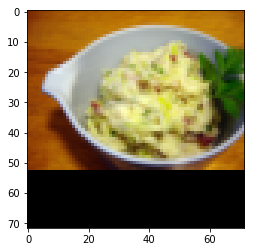

In [47]:
plt.imshow(arr_lr[10].astype('uint8'));

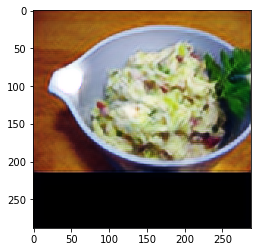

In [48]:
plt.imshow(p[0].astype('uint8'));

In [49]:
top_model.save_weights(path + 'lesson9/results/' + 'sr_final.h5')

In [ ]:
top_model.load_weights(path + 'lesson9/results/' + 'sr_final.h5')

The important thing to take away here is that as opposed to our earlier approaches, this type of approach results in a model that can create the desired image and is a scalable implementation.

Note that we haven't used a test ste here, so we don't know if the above result is due to over-fitting.

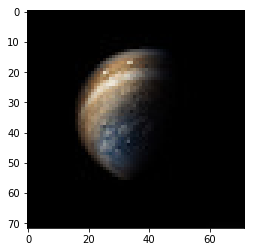

In [55]:
# well, since you mention it:
mofolo_jup = Image.open(path + 'sr-imgs/Jupiter-Juno-LR.jpeg')
mofolo_jup = np.expand_dims(np.array(mofolo_jup), 0)

p = top_model.predict(mofolo_jup)

# lores Jupiter
plt.imshow(mofolo_jup[0].astype('uint8'));

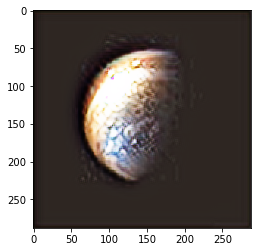

In [56]:
# superes Jupiter
plt.imshow(p[0].astype('uint8'))

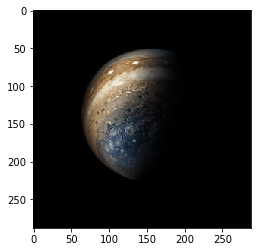

In [57]:
# original hires jupiter:
mofohi_jup = Image.open(path + 'sr-imgs/Jupiter-Juno-HR.jpg')
plt.imshow(mofohi_jup)

# Fast Style Transfer

The original paper showing the above approach to our super resolution also used this approach to createa a much faster style transfer system (for a specific style). Take a look at [the paper](https://arxiv.org/abs/1603.08155) and the very helpful [supplementary material](http://cs.stanford.edu/people/jcjohns/papers/eccv16/JohnsonECCV16Supplementary.pdf).

### Reflection Padding

The supplementary material mentions that they found reflection padding helpful - we have implemented this as a Keras layer. All the other layers and blocks are already defined above.

In [27]:
class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1,1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)
        
    def get_output_shape_for(self, s):
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])
    
    def call(self, x, mask=None):
        w_pad, h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad, h_pad], [w_pad, w_pad], [0,0] ], 'REFLECT')

Testing the reflection padding layer:

In [28]:
inp = Input((288, 288, 3))
ref_model = Model(inp, ReflectionPadding2D((40, 10))(inp))
ref_model.compile('adam', 'mse')

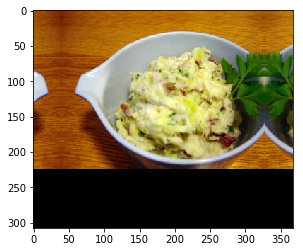

In [29]:
p = ref_model.predict(arr_hr[10:11])
plt.imshow(p[0].astype('uint8'))

### Main Algorithm

This approach is exactly the same as super resoltuion, except now the loss includes the style loss.

In [30]:
shp = arr_hr.shape[1:]

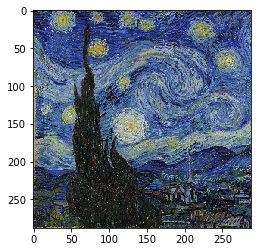

In [31]:
style = Image.open(path + 'nst/starry-night.png')
# style = style.resize(np.divide(style.size, 3.5).astype('int32'))
style = np.array(style)[:shp[0], :shp[1], :shp[2]]
plt.imshow(style);

In [32]:
def res_crop_block(ip, nf=64):
    x = conv_block(ip, nf, 3, (1,1,), 'valid')
    x = conv_block(x, nf, 3, (1,1), 'valid', False)
    ip = Lambda(lambda x: x[:, 2:-2, 2:-2])(ip)
    return merge([x, ip], mode='sum')

In [33]:
inp=Input(shp)
x=ReflectionPadding2D((40,40))(inp)
x=conv_block(x, 64, 9, (1,1))
x=conv_block(x, 64, 3)
x=conv_block(x, 64, 3)
for i in range(5): x=res_crop_block(x)
x=up_block(x, 64, 3)
x=up_block(x, 64, 3)
x=Convolution2D(3, 9, 9, activation='tanh', border_mode='same')(x)
outp=Lambda(lambda x: (x+1)*128.5)(x)

In [34]:
vgg_inp=Input(shp)
vgg=VGG16(include_top=False, input_tensor=Lambda(preproc)(vgg_inp))
for λ in vgg.layers: λ.trainable=False

In [35]:
def get_outp(m, ln): return m.get_layer(f'block{ln}_conv2').output
vgg_content = Model(vgg_inp, [get_outp(vgg, o) for o in [2,3,4,5]])

Here we alter the super resolution approach by adding style outputs:

In [36]:
style_targs = [K.variable(o) for o in
               vgg_content.predict(np.expand_dims(style, 0))]

In [37]:
[K.eval(K.shape(o)) for o in style_targs]

[array([  1, 144, 144, 128], dtype=int32),
 array([  1,  72,  72, 256], dtype=int32),
 array([  1,  36,  36, 512], dtype=int32),
 array([  1,  18,  18, 512], dtype=int32)]

In [38]:
vgg1 = vgg_content(vgg_inp)
vgg2 = vgg_content(outp)

Our loss now includes the MSE for the content loss and the Gram Matrix for the style

In [39]:
def gram_matrix_b(x):
    x = K.permute_dimensions(x, (0, 3, 1, 2))
    s = K.shape(x)
    feat = K.reshape(x, (s[0], s[1], s[2]*s[3]))
    return K.batch_dot(feat, K.permute_dimensions(feat, (0, 2, 1))
                      ) / K.prod(K.cast(s[1:], K.floatx()))

w = [0.1, 0.2, 0.6, 0.1]
def tot_loss(x):
    loss = 0; n = len(style_targs)
    for i in range(n):
        loss += mean_sqr_b(gram_matrix_b(x[i+n]) - gram_matrix_b(style_targs[i])) / 2.
        loss += mean_sqr_b(x[i]-x[i+n]) * w[i]
    return loss

In [40]:
loss = Lambda(tot_loss)(vgg1 + vgg2)
m_style = Model([inp, vgg_inp], loss)
targ = np.zeros((arr_hr.shape[0], 1))

In [43]:
m_style.compile('adam', 'mse')
m_style.fit([arr_hr, arr_hr], targ, 4, 2, **pars)

In [44]:
m_style.save_weights(path + 'lesson9/results/' + 'style_final.h5')

In [45]:
K.set_value(m_style.optimizer.lr, 1e-4)
m_style.fit([arr_hr, arr_hr], targ, 4, 1, **pars)

In [46]:
top_model = Model(inp, outp)

Now we can pass any image through this CNN and it'll prodice the desired style.

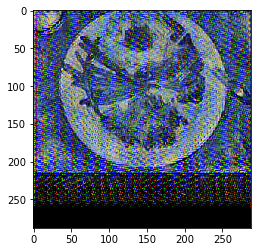

In [57]:
p = top_model.predict(arr_hr[:10])
plt.imshow(np.round(p[0]).astype('uint8'))

*this is kind of hillarious*

In [58]:
top_model.save_weights(path + 'lesson9/results/style_final.h5')
# top_model.load_weights(path + 'lesson9/results/style_final.h5')

### Next Steps:

ideas:

* https://github.com/junyanz/iGAN
* https://arxiv.org/abs/1605.04603
* https://arxiv.org/abs/1606.05897
* http://cs231n.stanford.edu/reports2016/208_Report.pdf